# Training Neural Networks

The network we built in the previous part isn't so smart, it doesn't know anything about our handwritten digits. Neural networks with non-linear activations work like universal function approximators. There is some function that maps your input to the output. For example, images of handwritten digits to class probabilities. The power of neural networks is that we can train them to approximate this function, and basically any function given enough data and compute time.


## Losses in PyTorch

Let's start by seeing how we calculate the loss with PyTorch. Through the `nn` module, PyTorch provides losses such as the cross-entropy loss (`nn.CrossEntropyLoss`). You'll usually see the loss assigned to `criterion`. As noted in the last part, with a classification problem such as MNIST, we're using the softmax function to predict class probabilities. With a softmax output, you want to use cross-entropy as the loss. To actually calculate the loss, you first define the criterion then pass in the output of your network and the correct labels.

Something really important to note here. Looking at [the documentation for `nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss),

> This criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.
>
> The input is expected to contain scores for each class.

This means we need to pass in the raw output of our network into the loss, not the output of the softmax function. This raw output is usually called the *logits* or *scores*. We use the logits because softmax gives you probabilities which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one ([read more here](https://docs.python.org/3/tutorial/floatingpoint.html)). It's usually best to avoid doing calculations with probabilities, typically we use log-probabilities.

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
print (trainloader)

### Feed-Forward and Compute Loss (Error)
Lett's build a neural network and push one batch of training images through the model to complete a feed-forward process.

In [6]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))
print (model)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)
print(images.shape)
# Forward pass, get our logits
logits = model(images)
print(logits.shape)
print(labels.shape)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)
print(loss.shape)
print(loss)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
)
torch.Size([64, 784])
torch.Size([64, 10])
torch.Size([64])
torch.Size([])
tensor(2.3123, grad_fn=<NllLossBackward0>)


It's more convenient to build the model with a log-softmax output using `nn.LogSoftmax` or `F.log_softmax` ([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.LogSoftmax)). Then you can get the actual probabilities by taking the exponential `torch.exp(output)`. With a log-softmax output, you want to use the negative log likelihood loss, `nn.NLLLoss` ([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss)).

>**Experiment With Code:** Build a model that returns the log-softmax as the output and calculate the loss using the negative log likelihood loss. Note that for `nn.LogSoftmax` and `F.log_softmax` you'll need to set the `dim` keyword argument appropriately. `dim=0` calculates softmax across the rows, so each column sums to 1, while `dim=1` calculates across the columns so each row sums to 1. Think about what you want the output to be and choose `dim` appropriately.

In [7]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784,128),
                      nn.ReLU(),
                      nn.Linear(128,64),
                      nn.ReLU(),
                      nn.Linear(64,10),
                      nn.LogSoftmax(dim=1))

# Define the loss
criterion = nn.NLLLoss()

### Run this to check your work
# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.3050, grad_fn=<NllLossBackward0>)


### Backpropagation = Automatic Computing of Gradient

Now that we know how to calculate a loss, how do we use it to perform backpropagation? Torch provides a module, `autograd`, for automatically calculating the gradients of tensors. We can use it to calculate the gradients of all our parameters with respect to the loss. Autograd works by keeping track of operations performed on tensors, then going backwards through those operations, calculating gradients along the way. To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set `requires_grad = True` on a tensor. You can do this at creation with the `requires_grad` keyword, or at any time with `x.requires_grad_(True)`.

You can turn off gradients for a block of code with the `torch.no_grad()` content:
```python
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```

Also, you can turn on or off gradients altogether with `torch.set_grad_enabled(True|False)`.

The gradients are computed with respect to some variable `z` with `z.backward()`. This does a backward pass through the operations that created `z`.

In [8]:
x = torch.randn(3,3, requires_grad=True)
print(x)

tensor([[-0.9547,  1.3320,  0.8667],
        [-1.2489, -0.1890,  0.9410],
        [-0.6057,  0.7495, -1.2559]], requires_grad=True)


In [9]:
y = x**2
print(y)

tensor([[0.9114, 1.7743, 0.7511],
        [1.5598, 0.0357, 0.8855],
        [0.3669, 0.5618, 1.5772]], grad_fn=<PowBackward0>)


Below we can see the operation that created `y`, a power operation `PowBackward0`.

In [10]:
## grad_fn shows the function that generated this variable
print(y.grad_fn)

The autograd module keeps track of these operations and knows how to calculate the gradient for each one. In this way, it's able to calculate the gradients for a chain of operations, with respect to any one tensor. Let's reduce the tensor `y` to a scalar value, the mean.

In [11]:
z = y.mean()
print(z)

tensor(0.9360, grad_fn=<MeanBackward0>)


You can check the gradients for `x` and `y` but they are empty currently.

In [12]:
print(x.grad)
print(y.grad)

None
None


<ipython-input-12-cd4c40187c02>:2: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  print(y.grad)


Because the original x is definted with "requires_grad=True", Pytorch is aware of this chain of
z = y.mean() [notice grad_fn=<MeanBackward0> in the printout of tensor z] and y = x**2 [notice grad_fn=<PowBackward0> in the printout of tensor y].

To calculate the gradients, you need to run the `.backward` method on a Variable, `z` for example. This will calculate the gradient for `z` with respect to `x`. Mathmatically, since z = y.mean() and y = x**2, with `x` as a matrix and $x_i$ as one of the elements in `x`, we have:
$$z=\frac{1}{n}\sum_i^n x_i^2$$
We can prove that:
\begin{align}
\frac{\partial z}{\partial x_i} &= \frac{\partial}{\partial x}\left(\frac{1}{n}\sum_i^n x_i^2\right) \\
&= \frac{\partial [1/n(x_1^2+...+x_i^2+...+x_n^2)]}{\partial x_i}\\
&= \frac{2x_i}{n}
\end{align}

With `x` as a matrix, for example, of size 3x3:
$$
x=
\begin{bmatrix}
x_{11} & x_{12} & x_{13}\\
x_{21} & x_{22} & x_{23}\\
x_{31} & x_{32} & x_{33}
\end{bmatrix}
$$
the scaler-by-matrix differentation is
$$
\frac{\partial z}{\partial x} =
\begin{bmatrix}
\frac{\partial z}{\partial x_{11}} & \frac{\partial z}{\partial x_{12}} & \frac{\partial z}{\partial x_{13}}\\
\frac{\partial z}{\partial x_{21}} & \frac{\partial z}{\partial x_{22}} & \frac{\partial z}{\partial x_{23}}\\
\frac{\partial z}{\partial x_{31}} & \frac{\partial z}{\partial x_{32}} & \frac{\partial z}{\partial x_{33}}\\
\end{bmatrix}
$$
In this case, n=9, and we have
$$
\frac{\partial z}{\partial x_{ij}} = \frac{2x_{ij}}{9}
$$
The following code shows that `z.backward()` computes the gradient for a 3x3 `x` exactly the same as its closed form:

In [13]:
z.backward()
print(z)
print("x.grad:", x.grad)
print("2*x/9:", 2*x/9)

tensor(0.9360, grad_fn=<MeanBackward0>)
x.grad: tensor([[-0.2121,  0.2960,  0.1926],
        [-0.2775, -0.0420,  0.2091],
        [-0.1346,  0.1666, -0.2791]])
2*x/9: tensor([[-0.2121,  0.2960,  0.1926],
        [-0.2775, -0.0420,  0.2091],
        [-0.1346,  0.1666, -0.2791]], grad_fn=<DivBackward0>)


These gradients calculations are particularly useful for neural networks. For training we need the gradients of the cost with respect to the weights. With PyTorch, we run data forward through the network to calculate the loss, then, go backwards to calculate the gradients with respect to the loss. Once we have the gradients we can make a gradient descent step.

## Loss and Autograd together

When we create a network with PyTorch, all of the parameters are initialized with `requires_grad = True`. This means that when we calculate the loss and call `loss.backward()`, the gradients for the parameters are calculated. These gradients are used to update the weights with gradient descent. Below you can see an example of calculating the gradients using a backwards pass.

In [14]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))  # this line is extra comparing to earlier nn.Sequential calls

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)

In [15]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0014, -0.0014, -0.0014,  ..., -0.0014, -0.0014, -0.0014],
        [ 0.0030,  0.0030,  0.0030,  ...,  0.0030,  0.0030,  0.0030],
        [ 0.0018,  0.0018,  0.0018,  ...,  0.0018,  0.0018,  0.0018],
        ...,
        [ 0.0034,  0.0034,  0.0034,  ...,  0.0034,  0.0034,  0.0034],
        [ 0.0002,  0.0002,  0.0002,  ...,  0.0002,  0.0002,  0.0002],
        [-0.0006, -0.0006, -0.0006,  ..., -0.0006, -0.0006, -0.0006]])


## Training the network!

There's one last piece we need to start training, an optimizer that we'll use to update the weights with the gradients. We get these from PyTorch's [`optim` package](https://pytorch.org/docs/stable/optim.html). For example we can use stochastic gradient descent with `optim.SGD`. You can see how to define an optimizer below.

In [16]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)
print(model.parameters())
for parameter in model.parameters():
    print(parameter.shape)

<generator object Module.parameters at 0x798d300165e0>
torch.Size([128, 784])
torch.Size([128])
torch.Size([64, 128])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


Now we know how to use all the individual parts so it's time to see how they work together. Let's consider just one learning step before looping through all the data. The general process with PyTorch:

* Make a forward pass through the network
* Use the network output to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

Below I'll go through one training step and print out the weights and gradients so you can see how it changes. Note that I have a line of code `optimizer.zero_grad()`. When you do multiple backwards passes with the same parameters, the gradients are accumulated. This means that you need to zero the gradients on each training pass or you'll retain gradients from previous training batches.

In [17]:
print('Initial weights - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784) # another way to flatten

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model[0].weight.grad)

Initial weights -  Parameter containing:
tensor([[-0.0251,  0.0200, -0.0273,  ...,  0.0154, -0.0278,  0.0023],
        [-0.0195, -0.0051, -0.0034,  ...,  0.0304, -0.0203,  0.0284],
        [-0.0056,  0.0252, -0.0083,  ...,  0.0039,  0.0066, -0.0226],
        ...,
        [-0.0153,  0.0239,  0.0118,  ..., -0.0061, -0.0319,  0.0115],
        [-0.0171,  0.0057, -0.0135,  ..., -0.0019, -0.0031,  0.0223],
        [-0.0003, -0.0330,  0.0054,  ..., -0.0153, -0.0102, -0.0025]],
       requires_grad=True)
Gradient - tensor([[ 4.0102e-03,  4.0102e-03,  4.0102e-03,  ...,  4.0102e-03,
          4.0102e-03,  4.0102e-03],
        [-3.3041e-04, -3.3041e-04, -3.3041e-04,  ..., -3.3041e-04,
         -3.3041e-04, -3.3041e-04],
        [ 7.6902e-05,  7.6902e-05,  7.6902e-05,  ...,  7.6902e-05,
          7.6902e-05,  7.6902e-05],
        ...,
        [ 2.8519e-03,  2.8519e-03,  2.8519e-03,  ...,  2.8519e-03,
          2.8519e-03,  2.8519e-03],
        [-4.0199e-04, -4.0199e-04, -4.0199e-04,  ..., -4.0199e

In [18]:
# Take an update step and few the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[-0.0251,  0.0199, -0.0274,  ...,  0.0154, -0.0279,  0.0023],
        [-0.0195, -0.0051, -0.0034,  ...,  0.0304, -0.0203,  0.0284],
        [-0.0056,  0.0252, -0.0083,  ...,  0.0039,  0.0066, -0.0226],
        ...,
        [-0.0154,  0.0239,  0.0118,  ..., -0.0061, -0.0319,  0.0115],
        [-0.0170,  0.0057, -0.0135,  ..., -0.0019, -0.0031,  0.0223],
        [-0.0003, -0.0330,  0.0054,  ..., -0.0153, -0.0102, -0.0025]],
       requires_grad=True)


### Training for real

Now we'll put this algorithm into a loop so we can go through all the images. Some nomenclature, one pass through the entire dataset is called an *epoch*. So here we're going to loop through `trainloader` to get our training batches. For each batch, we'll doing a training pass where we calculate the loss, do a backwards pass, and update the weights.

>**Final Project:** This is the training pass for our network. If implemented correctly, you should see the training loss drop with each epoch.

In [19]:
# TODO: design and build up your NN model and train it using MNIST data set

Try to plot the loss per batch per epoch. This is just a reference, you can come up with your own visualization.
`losses` is the variable storing the accumulated error (loss) from your training above

Length of trainloader:938
Epoch 1 - Training loss: 0.009901814852442308
Epoch 2 - Training loss: 0.009551744957428191


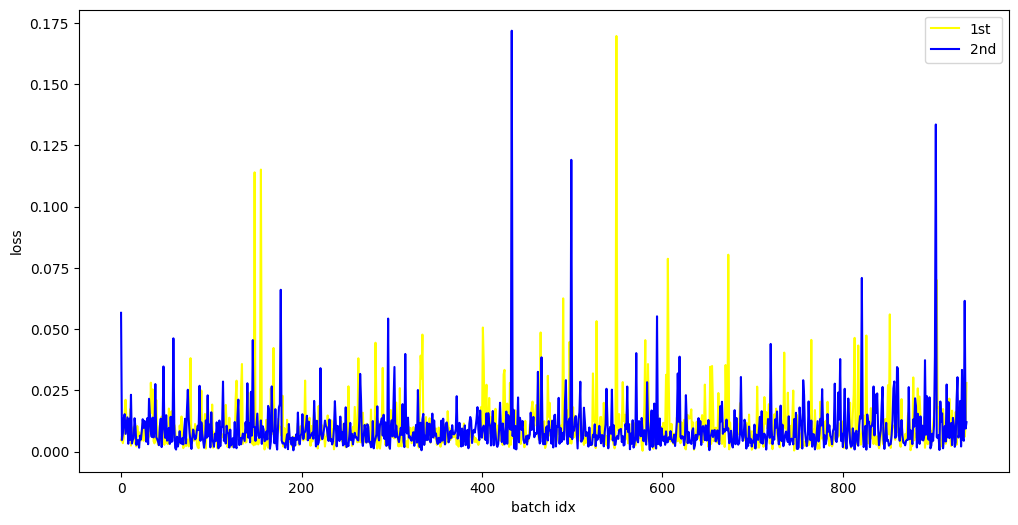

In [153]:
from functools import total_ordering
import matplotlib.pyplot as plt
import numpy as np
import copy
x = np.arange(938)
losses = [[],[],[],[],[],[],[],[],[],[],[],[],[],[]]
print (f"Length of trainloader:{len(trainloader)}")


for epoch in range(2):
  total_loss = 0
  for index, (tuple_images,tuple_label) in enumerate(trainloader):

    # parse tuple data
    image = tuple_images
    label = tuple_label

    # manipulate data
    image = image.view(image.shape[0], -1)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    # get data for graph
    total_loss += loss.item()
    losses[epoch].append(loss.item())

  print(f"Epoch {epoch+1} - Training loss: {total_loss/len(trainloader)}")


plt.figure(figsize=[12, 6])
plt.plot(x, losses[0], color='yellow', label="1st")
plt.plot(x, losses[1], color='b', label="2nd")
#plt.plot(x, losses[2], color='r', label="3rd")
#plt.plot(x, losses[3], color='g', label="4th")
#plt.plot(x, losses[4], color='orange', label="5th")
#plt.plot(x, losses[9], color='black', label="9th")
plt.xlabel('batch idx')
plt.ylabel('loss')
plt.legend()
plt.show()




### Test the Trained Model

With the neural network trained, we can check out its classification using the test images.
>**Experiment With Code** Change the index of images[ ] (within [0, 63] since we only have 64 images within on batch) to check out predictions for other handwriten digits. - here we are using the training images to test our model



tensor([[9.9997e-01, 5.3892e-10, 2.7316e-05, 5.0398e-13, 8.7885e-20, 6.3201e-12,
         9.8729e-10, 4.6376e-10, 2.3406e-15, 3.6437e-10]])
tensor(0)


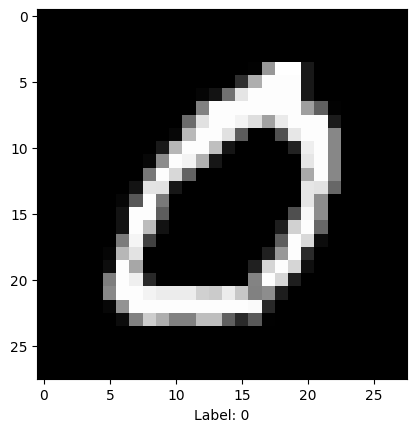

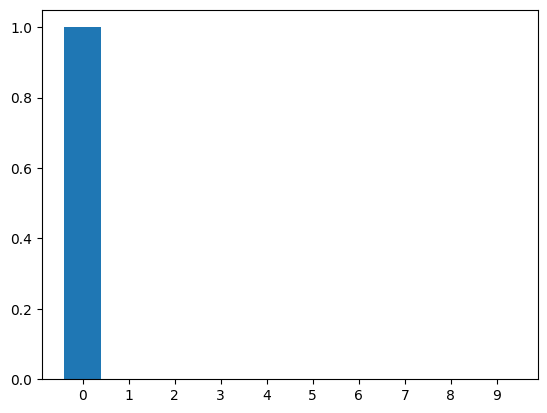

In [152]:
%matplotlib inline
import helper

graph_labels = ["0","1","2","3","4","5","6","7","8","9"]

images, labels = next(iter(trainloader))

img = images[33].view(1, 784)
print_out = images[33]
true_label = labels[33]


with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)

A1 = plt.figure(1)
plt.xlabel('Label: '+ str(true_label.item()))
plt.imshow(print_out.permute(1,2,0), cmap='gray')
A1.show()

probabilities = ps[0]

A2 = plt.figure(2)
plt.bar(graph_labels, probabilities)
A2.show()

print(ps)
print(true_label)



Now our network is brilliant. It can accurately predict the digits in our images.
>**Final Project** Load images from our own handwritten digit sets, use your trained nerual network model to do the classification and gather accuracy data. - the module should have not seen these test images, wonder how it will perform. Have fun!